<a href="https://colab.research.google.com/github/RenataKostolina/Machine_learning/blob/main/nn_for_satellite_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import pickle
from skimage import io

import PIL

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/dataset.zip

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
!ls train

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


In [ ]:
class Landscape(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('./train/')
VAL_TEST_DIR = Path('./val_test')

In [ ]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
val_test_files = sorted(list(VAL_TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_labels = [path.parent.name for path in train_files]
val_test_labels = [path.parent.name for path in val_test_files]

In [ ]:
val_files, test_files = train_test_split(val_test_files, test_size=0.25, \
                                          stratify=val_test_labels, random_state=42)

In [ ]:
import pandas as pd
data = pd.DataFrame(train_labels, columns=['name'])
data['count'] = 1
data = data.groupby('name').count().sort_values('count')

<ipython-input-14-7539dfddc275>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index , y='count', data=data, palette='flare')


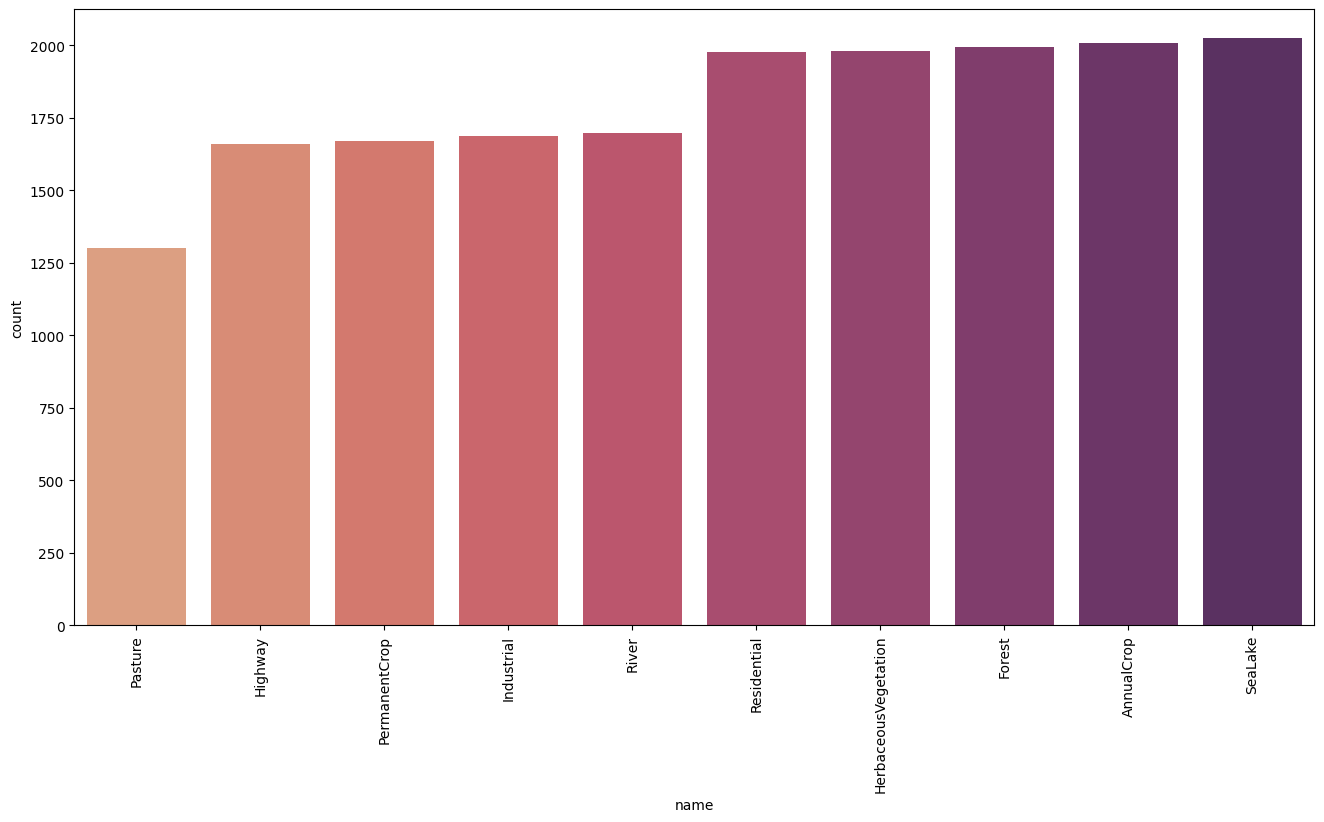

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.barplot(x=data.index , y='count', data=data, palette='flare')
plt.xticks(rotation=90)
plt.show()

In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

In [ ]:
data = pd.DataFrame(train_labels, columns=['name'])
data['count'] = 1
data = data.groupby('name').count().sort_values('count')

In [ ]:
data['iteration'] = 4000 - data['count']
data.loc[data['iteration']<0, 'iteration'] = 0

In [ ]:
augmenters = transforms.RandomChoice([
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomPerspective(distortion_scale=0.7),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=1)
])

In [ ]:
for image_path in tqdm(train_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    num_iter = round(data.loc[character]['iteration']/data.loc[character]['count'])

    for i in range(num_iter):
        aug_img = augmenters(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}"+"_"+f"{i+1}.jpg")

100%|██████████| 18000/18000 [00:18<00:00, 988.69it/s] 


<ipython-input-20-e130d07742a9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index , y='count', data=data, palette='flare')


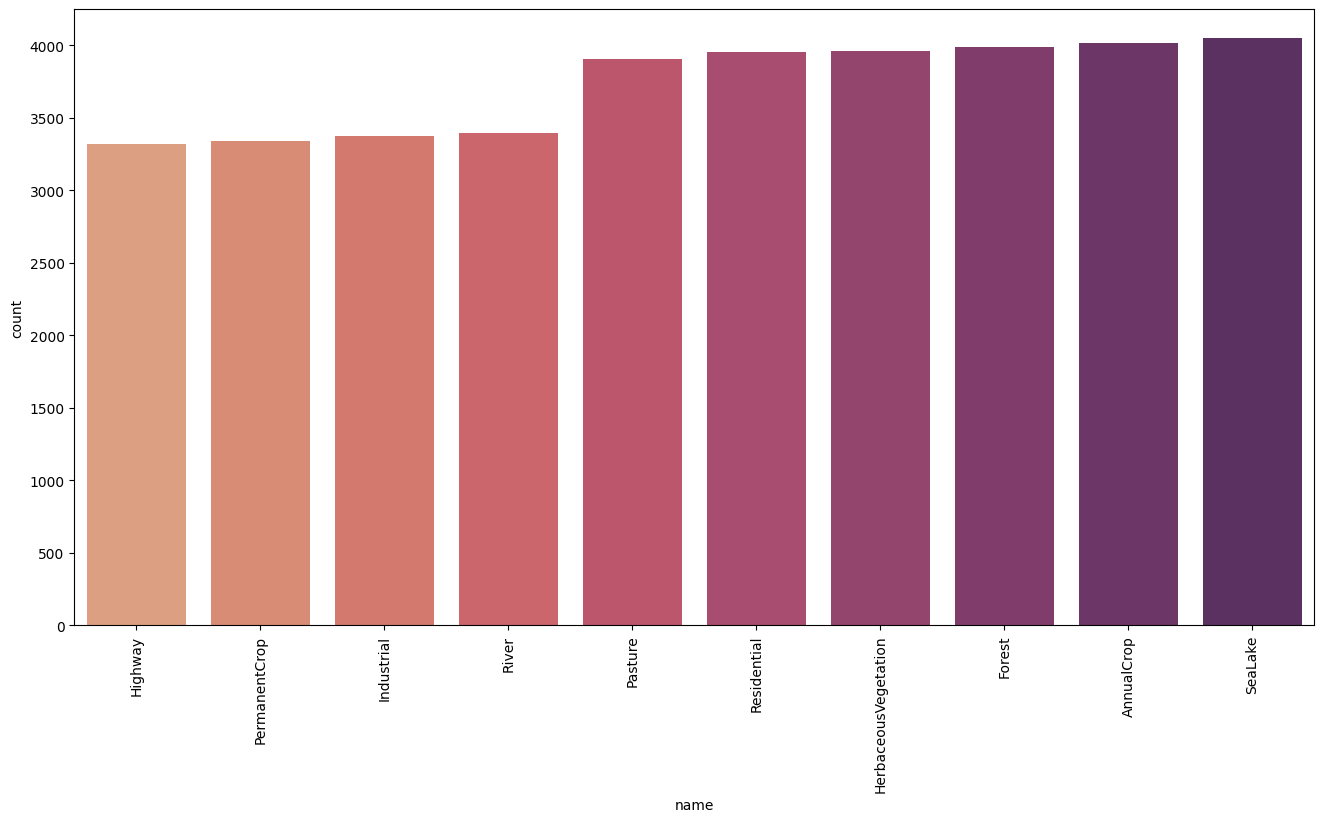

In [ ]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]

data = pd.DataFrame(train_labels, columns=['name'])
data['count'] = 1
data = data.groupby('name').count().sort_values('count')

plt.figure(figsize=(16,8))
sns.barplot(x=data.index , y='count', data=data, palette='flare')
plt.xticks(rotation=90)
plt.show()

In [ ]:
class Net(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(8),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(96),
            nn.Dropout(0.2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.2)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten()
        )
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=1152, out_features=4096),
            nn.ReLU()
        )
        self.linear2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        self.linear3 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=512),
            nn.ReLU()
        )
        self.out = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    scheduler.step()
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_dataset, batch_size):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_labels))
net = Net(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(net)

we will classify :10
Net(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace

In [ ]:
train_dataset = Landscape(train_files, mode='train')
val_dataset = Landscape(val_files, mode='val')
test_dataset = Landscape(test_files, mode='test')

In [ ]:
history = train(train_dataset, val_dataset, model=net, epochs = 20, batch_size=128)

epoch:   5%|▌         | 1/20 [02:39<50:36, 159.81s/it]


Epoch 001 train_loss: 1.0985     val_loss 2.3428 train_acc 0.6097 val_acc 0.4052


epoch:  10%|█         | 2/20 [05:10<46:24, 154.69s/it]


Epoch 002 train_loss: 0.7558     val_loss 0.5574 train_acc 0.7379 val_acc 0.8114


epoch:  15%|█▌        | 3/20 [07:39<43:02, 151.93s/it]


Epoch 003 train_loss: 0.5162     val_loss 0.4297 train_acc 0.8264 val_acc 0.8627


epoch:  20%|██        | 4/20 [10:07<40:03, 150.23s/it]


Epoch 004 train_loss: 0.3828     val_loss 0.3219 train_acc 0.8711 val_acc 0.8945


epoch:  25%|██▌       | 5/20 [12:36<37:29, 149.94s/it]


Epoch 005 train_loss: 0.3247     val_loss 0.2993 train_acc 0.8901 val_acc 0.9059


epoch:  30%|███       | 6/20 [15:07<35:03, 150.28s/it]


Epoch 006 train_loss: 0.2668     val_loss 0.3390 train_acc 0.9110 val_acc 0.8933


epoch:  35%|███▌      | 7/20 [17:38<32:37, 150.57s/it]


Epoch 007 train_loss: 0.2148     val_loss 0.2614 train_acc 0.9267 val_acc 0.9087


epoch:  40%|████      | 8/20 [20:08<30:03, 150.26s/it]


Epoch 008 train_loss: 0.0912     val_loss 0.1809 train_acc 0.9688 val_acc 0.9496


epoch:  45%|████▌     | 9/20 [22:38<27:32, 150.26s/it]


Epoch 009 train_loss: 0.0645     val_loss 0.1925 train_acc 0.9774 val_acc 0.9499


epoch:  50%|█████     | 10/20 [25:15<25:22, 152.21s/it]


Epoch 010 train_loss: 0.0520     val_loss 0.1957 train_acc 0.9821 val_acc 0.9508


epoch:  55%|█████▌    | 11/20 [27:44<22:43, 151.48s/it]


Epoch 011 train_loss: 0.0399     val_loss 0.2228 train_acc 0.9869 val_acc 0.9508


epoch:  60%|██████    | 12/20 [30:13<20:05, 150.71s/it]


Epoch 012 train_loss: 0.0329     val_loss 0.2458 train_acc 0.9891 val_acc 0.9492


epoch:  65%|██████▌   | 13/20 [32:51<17:48, 152.71s/it]


Epoch 013 train_loss: 0.0267     val_loss 0.2617 train_acc 0.9915 val_acc 0.9517


epoch:  70%|███████   | 14/20 [35:19<15:08, 151.50s/it]


Epoch 014 train_loss: 0.0186     val_loss 0.2867 train_acc 0.9945 val_acc 0.9481


epoch:  75%|███████▌  | 15/20 [37:50<12:36, 151.31s/it]


Epoch 015 train_loss: 0.0104     val_loss 0.2814 train_acc 0.9974 val_acc 0.9516


epoch:  80%|████████  | 16/20 [40:21<10:04, 151.13s/it]


Epoch 016 train_loss: 0.0082     val_loss 0.2890 train_acc 0.9981 val_acc 0.9508


epoch:  85%|████████▌ | 17/20 [42:52<07:33, 151.02s/it]


Epoch 017 train_loss: 0.0074     val_loss 0.2962 train_acc 0.9984 val_acc 0.9511


epoch:  90%|█████████ | 18/20 [45:22<05:01, 150.81s/it]


Epoch 018 train_loss: 0.0068     val_loss 0.3035 train_acc 0.9985 val_acc 0.9514


epoch:  95%|█████████▌| 19/20 [47:52<02:30, 150.50s/it]


Epoch 019 train_loss: 0.0063     val_loss 0.3112 train_acc 0.9987 val_acc 0.9507


epoch: 100%|██████████| 20/20 [50:22<00:00, 151.11s/it]


Epoch 020 train_loss: 0.0059     val_loss 0.3176 train_acc 0.9988 val_acc 0.9511


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
val_acc = [val_acc[i].item() for i in range(len(val_acc))]

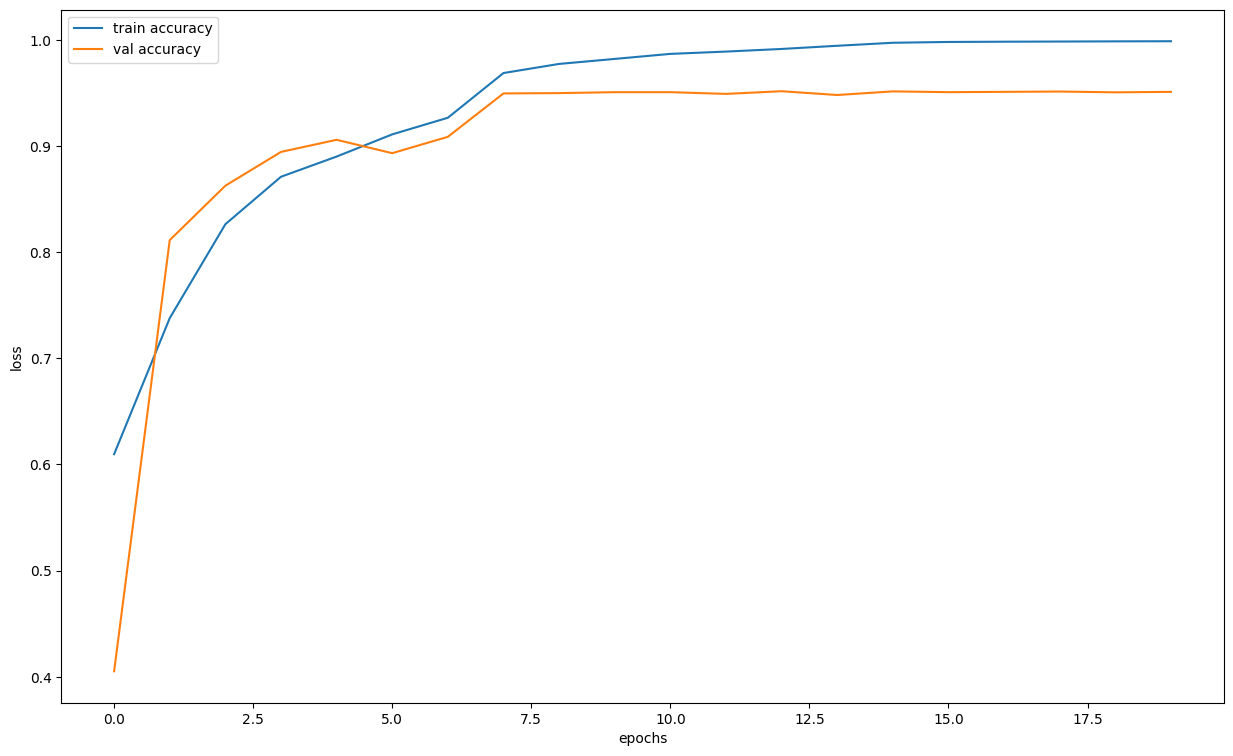

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train accuracy")
plt.plot(val_acc, label="val accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

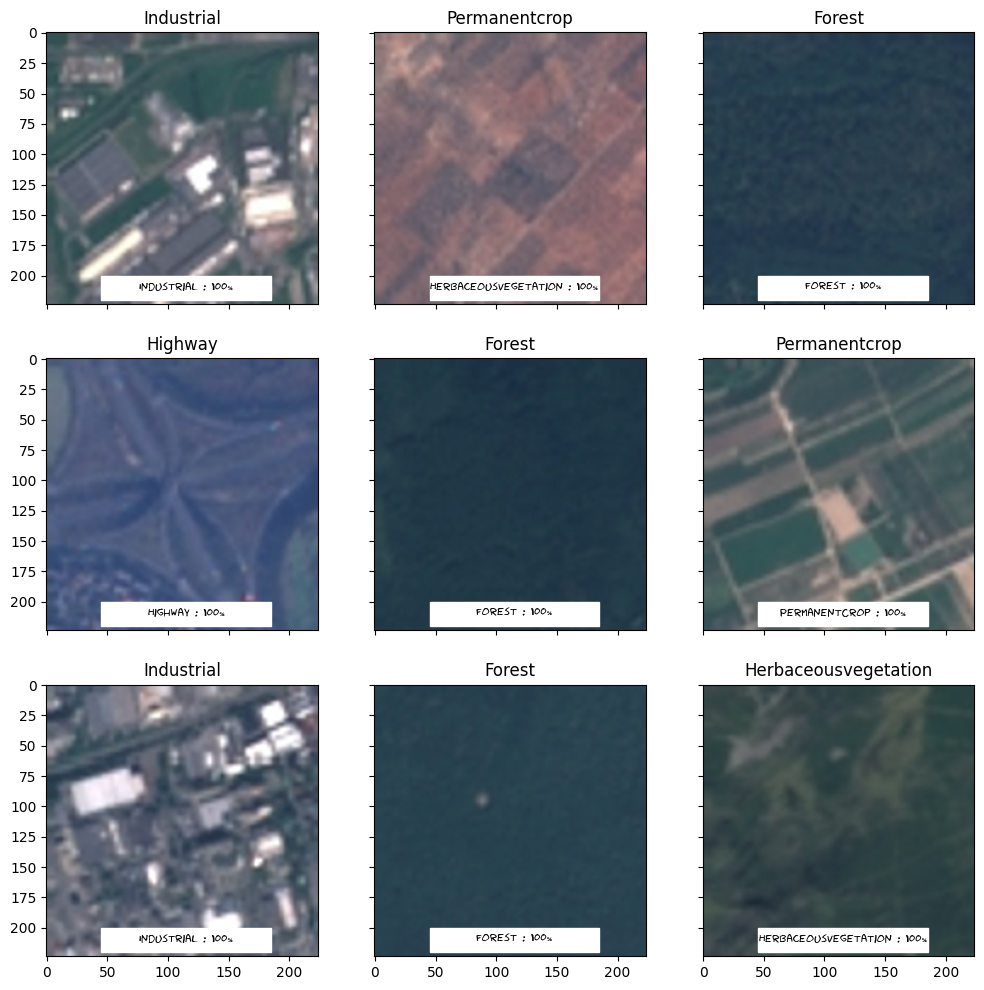

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((45, 200),140,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(net, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(115, 205, predicted_text , horizontalalignment='center', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_test = [path.name.split('_')[0] for path in test_dataset.files]

In [ ]:
probs = predict(net, test_dataset, batch_size=128)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
accuracy = accuracy_score(y_test, preds)

print("Accuracy:", '%.2f' %(accuracy*100))


Accuracy: 95.42


In [ ]:
from torchvision import models

In [ ]:
tuning_net = models.resnet50(weights="ResNet50_Weights.DEFAULT")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


In [ ]:
for param in tuning_net.parameters():
    param.requires_grad = False

In [ ]:
for name, param in tuning_net.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [ ]:
tuning_net.fc = nn.Linear(in_features=2048, out_features=n_classes, bias=True)
tuning_net = tuning_net.to(DEVICE)

In [ ]:
for name, param in tuning_net.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [ ]:
history = train(train_dataset, val_dataset, model=tuning_net, epochs = 5, batch_size=128)

epoch:  20%|██        | 1/5 [04:10<16:42, 250.73s/it]


Epoch 001 train_loss: 0.8307     val_loss 0.4232 train_acc 0.7648 val_acc 0.8846


epoch:  40%|████      | 2/5 [08:09<12:10, 243.58s/it]


Epoch 002 train_loss: 0.4590     val_loss 0.3267 train_acc 0.8601 val_acc 0.9064


epoch:  60%|██████    | 3/5 [12:08<08:03, 241.68s/it]


Epoch 003 train_loss: 0.3827     val_loss 0.2839 train_acc 0.8801 val_acc 0.9172


epoch:  80%|████████  | 4/5 [16:08<04:00, 240.78s/it]


Epoch 004 train_loss: 0.3374     val_loss 0.2632 train_acc 0.8947 val_acc 0.9201


epoch: 100%|██████████| 5/5 [20:09<00:00, 241.95s/it]


Epoch 005 train_loss: 0.3060     val_loss 0.2495 train_acc 0.9040 val_acc 0.9247


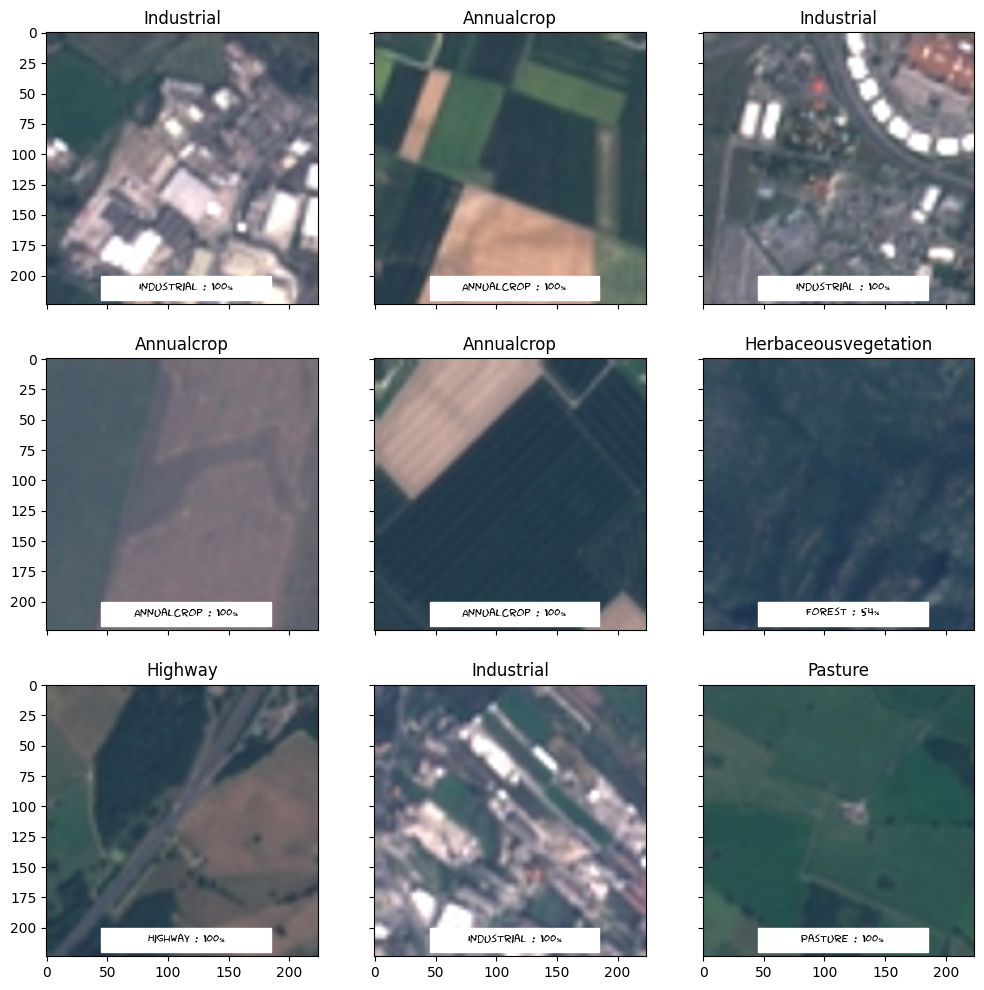

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((45, 200),140,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(net, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(115, 205, predicted_text , horizontalalignment='center', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
probs = predict(tuning_net, test_dataset, batch_size=128)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
accuracy = accuracy_score(y_test, preds)

print("Accuracy:", '%.2f' %(accuracy*100))

Accuracy: 92.44
